## Работа с ориентированным графами

Полная документация http://www.bnlearn.com/

Установите необходимые библиотеки

Еще несколько из репозитория пакетов для биоинформатики

А вот теперь можно поставить еще один пакет из основного репозитория

Подключим все пакеты

In [1]:
library('visNetwork')
library('Rgraphviz')
library('gRain')
library('compiler')
library('bnlearn')

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: grid

Loading required package: gRbase


Attachin

In [2]:
options(repr.plot.width = 10, repr.plot.height = 8)

Вспомогательная функция, для красивой визуализации графов

In [3]:
plot.network <- function(structure, ht = "400px"){
  nodes.uniq <- unique(c(structure$arcs[,1], structure$arcs[,2]))
  nodes <- data.frame(id = nodes.uniq,
                      label = nodes.uniq,
                      color = "darkturquoise",
                      shadow = TRUE)

  edges <- data.frame(from = structure$arcs[,1],
                      to = structure$arcs[,2],
                      arrows = "to",
                      smooth = TRUE,
                      shadow = TRUE,
                      color = "black")

  return(visNetwork(nodes, edges, height = ht, width = "100%"))
}

### Структура графов

Загрузим данные об оцентах 88 студентов по механике, векторам, алгебре, анализу и статистике. Все значения лежат в пределах от 0 до 100.

In [4]:
data(marks)
str(marks)

'data.frame':	88 obs. of  5 variables:
 $ MECH: num  77 63 75 55 63 53 51 59 62 64 ...
 $ VECT: num  82 78 73 72 63 61 67 70 60 72 ...
 $ ALG : num  67 80 71 63 65 72 65 68 58 60 ...
 $ ANL : num  67 70 66 70 70 64 65 62 62 62 ...
 $ STAT: num  81 81 81 68 63 73 68 56 70 45 ...


In [5]:
head(marks)

MECH,VECT,ALG,ANL,STAT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,82,67,67,81
63,78,80,70,81
75,73,71,66,81
55,72,63,70,68
63,63,65,70,63
53,61,72,64,73


Зададим матрицу ориентированных ребер, из которых далее построим граф

In [6]:
edges <- matrix(
 c("VECT", "MECH", "ALG", "MECH", "ALG", "VECT",
 "ANL", "ALG", "STAT", "ALG", "STAT", "ANL"),
 ncol = 2, byrow = TRUE,
 dimnames = list(c(), c("from", "to")))

edges

from,to
VECT,MECH
ALG,MECH
ALG,VECT
ANL,ALG
STAT,ALG
STAT,ANL


Зададим пустой граф, состоящий только из вершин, соответствующим нашим признакам. Далее установим ребра в графе

In [7]:
dag <- empty.graph(names(marks))
arcs(dag) <- edges

Визуализация графа

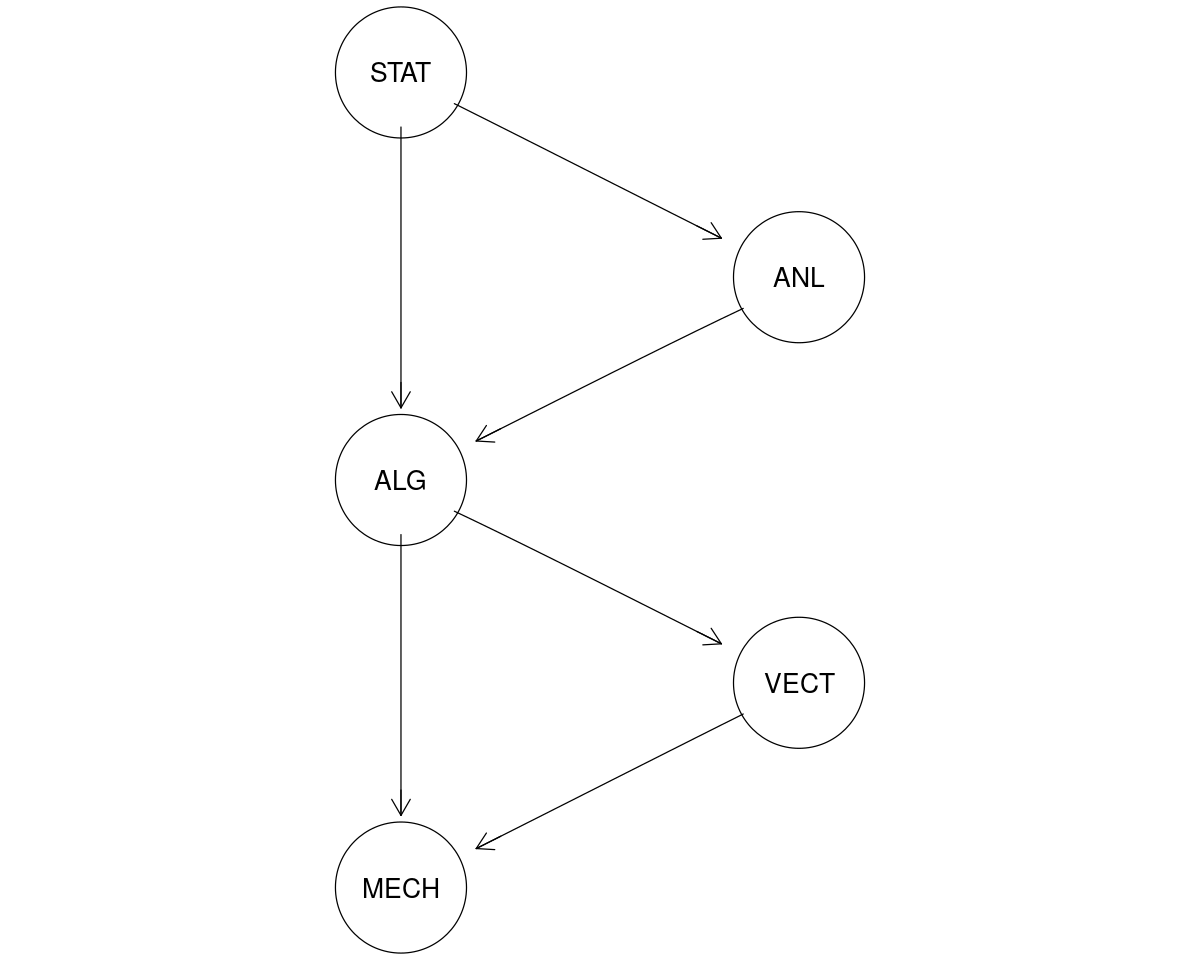

In [8]:
graphviz.plot(dag)

Посмотрим, как хранится информация об узлах графа.

Для каждого узла тут содежится следующая информяация:
* `parents` -- родители;
* `children` -- дети;
* `nbr` -- соседи (родители и дети);
* `mb` -- Markov blanket -- марковское ограждение узла. Это набор переменных, для которых верно, что переменная узла условно независима от всех остальных переменных в графе при условии марковского ограждения. Например, в примере ниже переменная MECH условно не зависит от всех остальных переменных графа (т.е. STAT, ANL) при условии VECT и ALG. Этот набор может не совпадать с соседями, если дети образуют коллайдр. Еще <a href="https://ru.wikipedia.org/wiki/Марковское_ограждение#/media/File:Diagram_of_a_Markov_blanket.svg">пример</a>;

In [9]:
dag$nodes

$MECH
$MECH$mb
[1] "VECT" "ALG" 

$MECH$nbr
[1] "VECT" "ALG" 

$MECH$parents
[1] "VECT" "ALG" 

$MECH$children
character(0)


$VECT
$VECT$mb
[1] "MECH" "ALG" 

$VECT$nbr
[1] "MECH" "ALG" 

$VECT$parents
[1] "ALG"

$VECT$children
[1] "MECH"


$ALG
$ALG$mb
[1] "MECH" "VECT" "ANL"  "STAT"

$ALG$nbr
[1] "MECH" "VECT" "ANL"  "STAT"

$ALG$parents
[1] "ANL"  "STAT"

$ALG$children
[1] "MECH" "VECT"


$ANL
$ANL$mb
[1] "ALG"  "STAT"

$ANL$nbr
[1] "ALG"  "STAT"

$ANL$parents
[1] "STAT"

$ANL$children
[1] "ALG"


$STAT
$STAT$mb
[1] "ALG" "ANL"

$STAT$nbr
[1] "ALG" "ANL"

$STAT$parents
character(0)

$STAT$children
[1] "ALG" "ANL"

Так можно извлечь информацию о конкретном узле. Чтобы извлечь, например, его родителей, нужно аналогично написать `dag$nodes$MECH$parents`.

In [10]:
dag$nodes$MECH

$mb
[1] "VECT" "ALG" 

$nbr
[1] "VECT" "ALG" 

$parents
[1] "VECT" "ALG" 

$children
character(0)

Извлечении матрицы ребер графа

In [11]:
dag$arcs

from,to
VECT,MECH
ALG,MECH
ALG,VECT
ANL,ALG
STAT,ALG
STAT,ANL


Есть и более цивилизованный способ извлечения информации о структуре графа.

Например, так можно вывести всех родителей вершины ALG.

**Внимание!** *Если у вас при выполнении следующего кода возникает ошибка, возможная проблема может быть в том, что при подключении другого пакета он переопределил имя функции. В таком случае явно укажите пакет `bnlearn::parents`.*

In [12]:
parents(dag, 'ALG')

[1] "ANL"  "STAT"

Код, проверяющий, является ли ANL родителем вершины ALG

In [13]:
'ANL' %in% parents(dag, 'ALG')

[1] TRUE

Потомки вершины ANL

In [14]:
descendants(dag, 'ANL')

[1] "ALG"  "VECT" "MECH"

Аналогичные операции существуют для ребер графа. Например, все исходящие ребра вершины ALG

In [15]:
outgoing.arcs(dag, 'ALG')

from,to
ALG,MECH
ALG,VECT


Полный список операций со структурой графа

Коллайдры графа

In [16]:
vstructs(dag, moral = TRUE)

X,Z,Y
VECT,MECH,ALG
ANL,ALG,STAT


Скелет графа (удаление ориентации ребер)

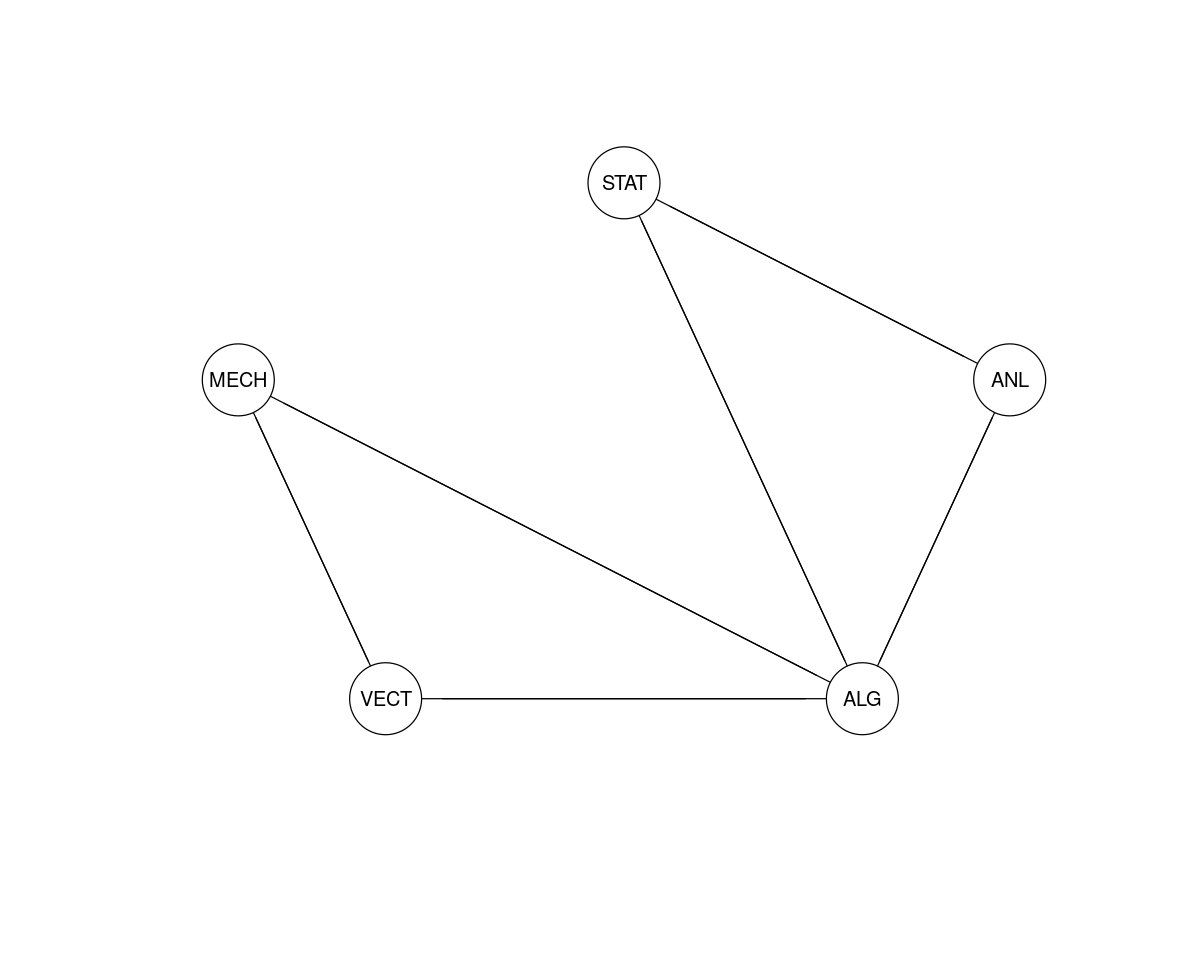

In [17]:
ug <- moral(dag)
plot(ug)

Граф можно задать по одному ребру

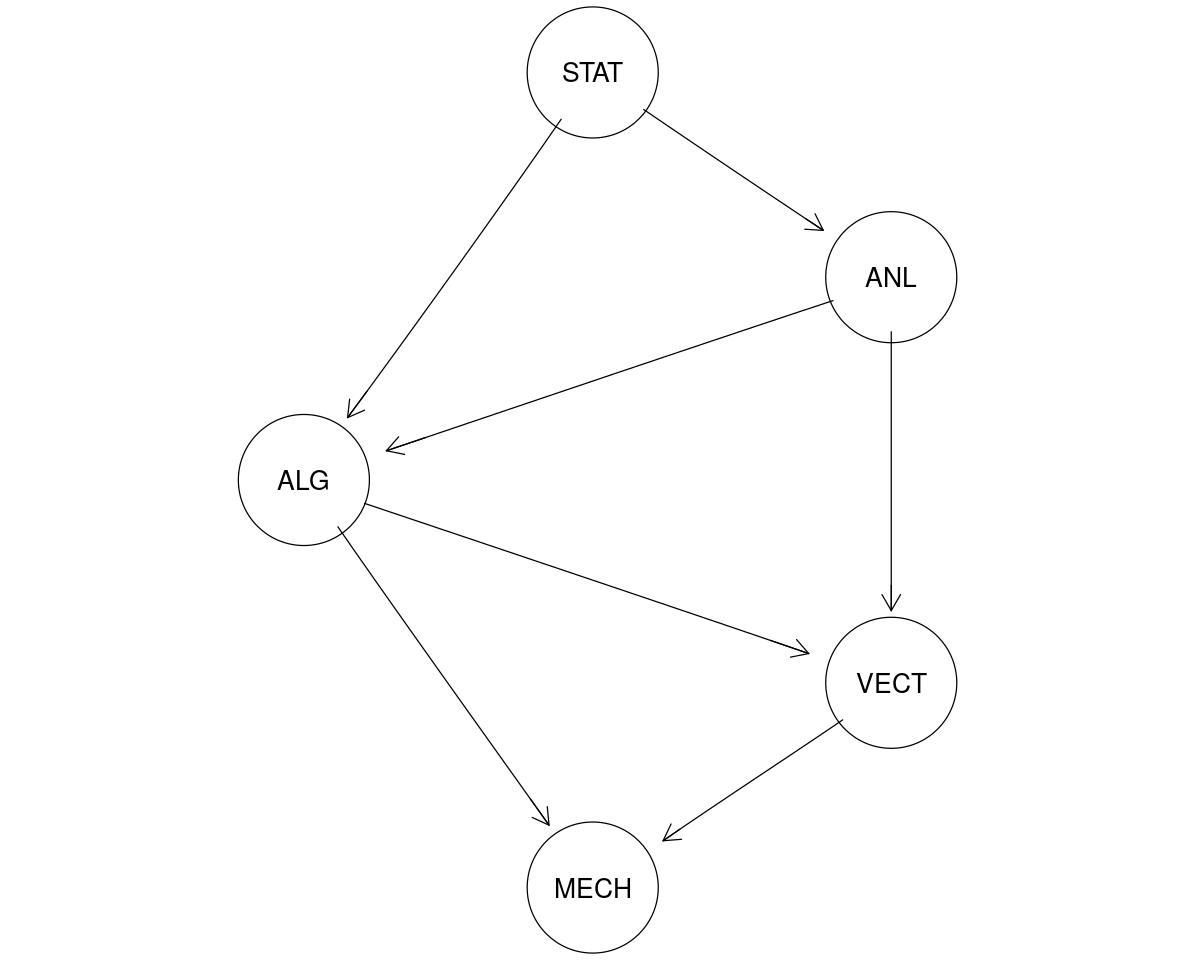

In [18]:
dag_1 <- empty.graph(nodes(dag))
dag_1 <- set.arc(dag_1, "VECT", "MECH")
dag_1 <- set.arc(dag_1, "ALG", "MECH")
dag_1 <- set.arc(dag_1, "ALG", "VECT")
dag_1 <- set.arc(dag_1, "ANL", "ALG")
dag_1 <- set.arc(dag_1, "STAT", "ALG")
dag_1 <- set.arc(dag_1, "STAT", "ANL")
dag_1 <- set.arc(dag_1, "ANL", "VECT")
graphviz.plot(dag_1)

Проверка на равенство графов

In [19]:
all.equal(dag, dag_1)

[1] "Different number of directed/undirected arcs"

### Оценка распределений в построенном графе

В функцию можно передать также параметр `method` -- метод оценки распределений. По умолчанию он равен `mle` (оценка максимального правдоподобия). Для дискретных данных можно указать `bayes`.

In [20]:
fitted <- bn.fit(dag, data = marks)

Посмотрим на то, что получилось. 

Поскольку наши данные непрерывны, распределения по умолчанию считаются гауссовскими. Информация ниже о переменной MECH говорит о том, что условное распределение MECH при условии VECT=x, ALG=y является нормальным со средним -12.36 + 0.47x + 0.55y и дисперсией 13.97^2.

In [21]:
fitted


  Bayesian network parameters

  Parameters of node MECH (Gaussian distribution)

Conditional density: MECH | VECT + ALG
Coefficients:
(Intercept)         VECT          ALG  
-12.3647583    0.4658693    0.5484053  
Standard deviation of the residuals: 13.97432 

  Parameters of node VECT (Gaussian distribution)

Conditional density: VECT | ALG
Coefficients:
(Intercept)          ALG  
 12.4183094    0.7543653  
Standard deviation of the residuals: 10.48167 

  Parameters of node ALG (Gaussian distribution)

Conditional density: ALG | ANL + STAT
Coefficients:
(Intercept)          ANL         STAT  
 24.7254768    0.3482454    0.2273881  
Standard deviation of the residuals: 6.871428 

  Parameters of node ANL (Gaussian distribution)

Conditional density: ANL | STAT
Coefficients:
(Intercept)         STAT  
 24.5824229    0.5223601  
Standard deviation of the residuals: 11.86392 

  Parameters of node STAT (Gaussian distribution)

Conditional density: STAT
Coefficients:
(Intercept)  
   4

Логарифм правдоподобия, AIC и BIC по обученно модели

In [22]:
logLik(fitted, data = marks)
AIC(fitted, data = marks)
BIC(fitted, data = marks)

[1] -1695.589

[1] -1711.589

[1] -1731.407

In [23]:
data(alarm)

Рассмотрим данные о мониторинговой системе за пациентами, состоящую из следующих датчиков:
* `CVP` (central venous pressure): a three-level factor with levels `LOW`, `LOW` and `HIGH`.
* `PCWP` (pulmonary capillary wedge pressure): a three-level factor with levels `LOW`, `NORMAL` and ``HIGH``.
* `HIST` (history): a two-level factor with levels `TRUE` and `FALSE`.
* `TPR` (total peripheral resistance): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `BP` (blood pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `CO` (cardiac output): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `HRBP` (heart rate / blood pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `HREK` (heart rate measured by an EKG monitor): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `HRSA` (heart rate / oxygen saturation): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `PAP` (pulmonary artery pressure): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `SAO2` (arterial oxygen saturation): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `FIO2` (fraction of inspired oxygen): a two-level factor with levels `LOW` and `NORMAL`.
* `PRSS` (breathing pressure): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.
* `ECO2` (expelled CO2): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.
* `MINV` (minimum volume): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.
* `MVS` (minimum volume set): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `HYP` (hypovolemia): a two-level factor with levels `TRUE` and `FALSE`.
* `LVF` (left ventricular failure): a two-level factor with levels `TRUE` and `FALSE`.
* `APL` (anaphylaxis): a two-level factor with levels `TRUE` and `FALSE`.
* `ANES` (insufficient anesthesia/analgesia): a two-level factor with levels `TRUE` and `FALSE`.
* `PMB` (pulmonary embolus): a two-level factor with levels `TRUE` and `FALSE`.
* `INT` (intubation): a three-level factor with levels `NORMAL`, `ESOPHAGEAL` and `ONESIDED`.
* `KINK` (kinked tube): a two-level factor with levels `TRUE` and `FALSE`.
* `DISC` (disconnection): a two-level factor with levels `TRUE` and `FALSE`.
* `LVV` (left ventricular end-diastolic volume): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `STKV` (stroke volume): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `CCHL` (catecholamine): a two-level factor with levels `NORMAL` and `HIGH`.
* `ERLO` (error `LOW` output): a two-level factor with levels `TRUE` and `FALSE`.
* `HR` (heart rate): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `ERCA` (electrocauter): a two-level factor with levels `TRUE` and `FALSE`.
* `SHNT` (shunt): a two-level factor with levels `NORMAL` and `HIGH`.
* `PVS` (pulmonary venous oxygen saturation): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `ACO2` (arterial CO2): a three-level factor with levels `LOW`, `NORMAL` and `HIGH`.
* `VALV` (pulmonary alveoli ventilation): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.
* `VLNG` (lung ventilation): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.
* `VTUB` (ventilation tube): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.
* `VMCH` (ventilation machine): a four-level factor with levels `ZERO`, `LOW`, `NORMAL` and `HIGH`.

In [24]:
head(alarm)

CVP,PCWP,HIST,TPR,BP,CO,HRBP,HREK,HRSA,PAP,⋯,ERLO,HR,ERCA,SHNT,PVS,ACO2,VALV,VLNG,VTUB,VMCH
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
NORMAL,NORMAL,FALSE,LOW,NORMAL,HIGH,HIGH,HIGH,HIGH,NORMAL,⋯,FALSE,HIGH,FALSE,NORMAL,NORMAL,NORMAL,HIGH,LOW,ZERO,NORMAL
NORMAL,NORMAL,FALSE,NORMAL,LOW,LOW,HIGH,HIGH,HIGH,NORMAL,⋯,FALSE,HIGH,FALSE,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
NORMAL,HIGH,FALSE,NORMAL,NORMAL,HIGH,HIGH,HIGH,HIGH,NORMAL,⋯,FALSE,HIGH,FALSE,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
NORMAL,NORMAL,FALSE,LOW,LOW,HIGH,HIGH,HIGH,HIGH,NORMAL,⋯,FALSE,HIGH,FALSE,NORMAL,NORMAL,LOW,ZERO,ZERO,LOW,NORMAL
NORMAL,NORMAL,FALSE,LOW,LOW,NORMAL,HIGH,HIGH,HIGH,NORMAL,⋯,FALSE,HIGH,FALSE,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL
NORMAL,NORMAL,FALSE,LOW,NORMAL,HIGH,HIGH,HIGH,HIGH,NORMAL,⋯,FALSE,HIGH,FALSE,NORMAL,LOW,LOW,ZERO,ZERO,LOW,NORMAL


In [25]:
options(repr.plot.width = 20, repr.plot.height = 20)

Зададим граф вручную через строку, в которой перечислим все непосредственные причинно-следственные связи. В текстовой строке каждой вершине должен соответствовать один блок из квадратных скобок. На первом месте ставится имя вершины. После вертикальной черты ставятся все родители вершины через двоеточие. Например, подстрока `[HYP]` соответствует вершине `HYP`, у которой нет родителей. Подстрока `[HRBP|ERLO:HR]` соответствует вершине `HRBP`, у которой двое родителей `ERLO` и `HR`.

HTML widgets cannot be represented in plain text (need html)

Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in CCHL, replaced with a uniform distribution.”
Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in ECO2, replaced with a uniform distribution.”
Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in PRSS, replaced with a uniform distribution.”
Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in VLNG, replaced with a uniform distribution.”


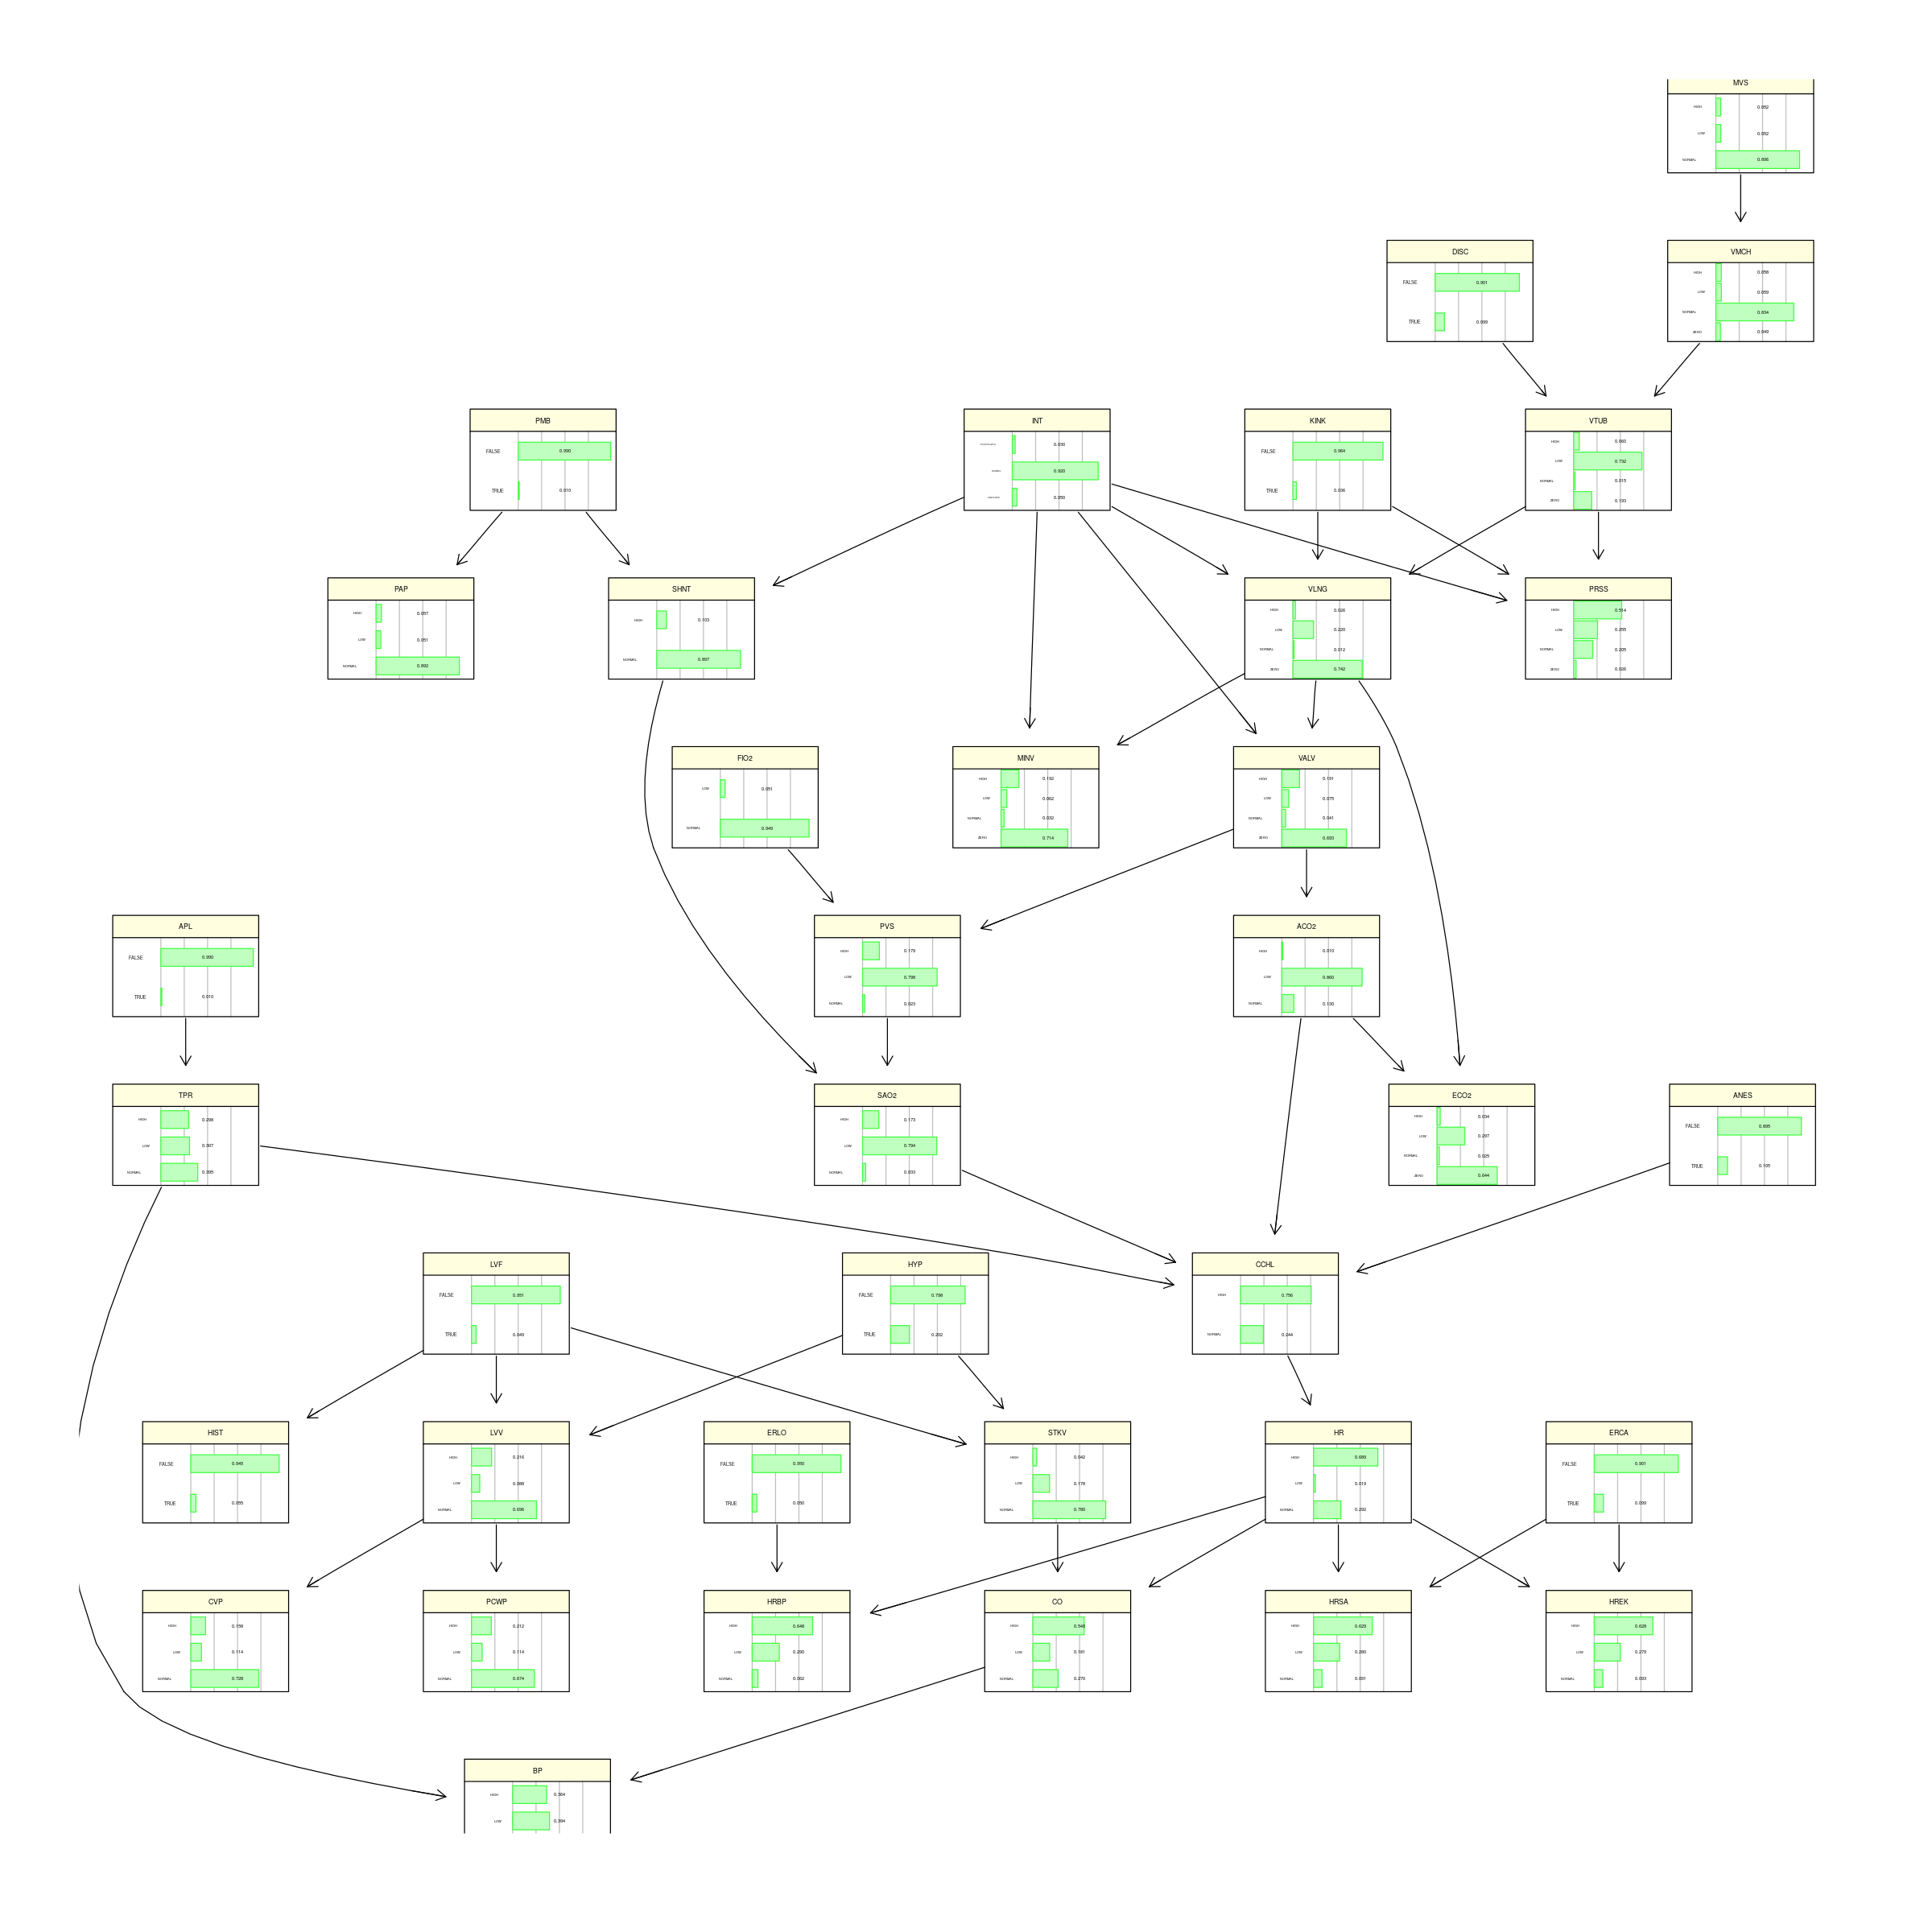

In [26]:
modelstring <- paste("[HIST|LVF][CVP|LVV][PCWP|LVV][HYP][LVV|HYP:LVF][LVF]",
  "[STKV|HYP:LVF][ERLO][HRBP|ERLO:HR][HREK|ERCA:HR][ERCA][HRSA|ERCA:HR][ANES]",
  "[APL][TPR|APL][ECO2|ACO2:VLNG][KINK][MINV|INT:VLNG][FIO2][PVS|FIO2:VALV]",
  "[SAO2|PVS:SHNT][PAP|PMB][PMB][SHNT|INT:PMB][INT][PRSS|INT:KINK:VTUB][DISC]",
  "[MVS][VMCH|MVS][VTUB|DISC:VMCH][VLNG|INT:KINK:VTUB][VALV|INT:VLNG][ACO2|VALV]",
  "[CCHL|ACO2:ANES:SAO2:TPR][HR|CCHL][CO|HR:STKV][BP|CO:TPR]", sep = "")
dag = model2network(modelstring)

# интерактивная визуализация
plot.network(dag, ht = "600px")

# оценка распределений
fitted = bn.fit(dag, alarm)

# визуализация
graphviz.chart(fitted, type = "barprob", grid = TRUE, 
               bar.col = "green", strip.bg = "lightyellow")

Посмотрим, как обучилась модель. Поскольку все величины категориальны, в качестве распредедения используется мультиномиальное распределение. В таблицах записаны условные вероятности. Например $\mathsf{P}(BP = HIGH\ |\ TPR = HIGH, CO = HIGH) = 0.8977$

In [27]:
fitted


  Bayesian network parameters

  Parameters of node ACO2 (multinomial distribution)

Conditional probability table:
 
        VALV
ACO2            HIGH         LOW      NORMAL        ZERO
  HIGH   0.008778931 0.015013055 0.001212121 0.010011524
  LOW    0.906092046 0.885117493 0.073939394 0.892250072
  NORMAL 0.085129024 0.099869452 0.924848485 0.097738404

  Parameters of node ANES (multinomial distribution)

Conditional probability table:
   FALSE    TRUE 
0.89535 0.10465 

  Parameters of node APL (multinomial distribution)

Conditional probability table:
  FALSE   TRUE 
0.9899 0.0101 

  Parameters of node BP (multinomial distribution)

Conditional probability table:
 
, , TPR = HIGH

        CO
BP              HIGH         LOW      NORMAL
  HIGH   0.897735573 0.092468307 0.542216764
  LOW    0.012417823 0.287844892 0.049124962
  NORMAL 0.089846603 0.619686801 0.408658274

, , TPR = LOW

        CO
BP              HIGH         LOW      NORMAL
  HIGH   0.010787992 0.007976072 0.006

### Условные вероятности

По построенному графу можно посчитать вероятности с помощью функции `cpquery` по принципу `cpquery(fitted, event, evidence)` есть вероятность $\mathsf{P}(event\ |\ evidence)$ по графу `fitted`. Например, вероятность $\mathsf{P}(CCHL = HIGH\ |\ VALV = HIGH)$ считается запросом ниже.

Вероятности вычисляются с помощью семплирования $n$ раз, поэтому для получения более точных результатов нужно выставить большое значение параметра `n`.

In [28]:
cpquery(fitted, 
        event = (CCHL == 'HIGH'), 
        evidence = (VALV == 'HIGH'), 
        n = 10^7)

[1] 0.6934908

События можно комбирировать с помощью логических операторов `&` (и) и `|` (или). Например, условная вероятность $\mathsf{P}\big(\{CCHL = HIGH\} \cap \{HRSA = LOW\}\ \big|\ \{VALV = HIGH\} \cup \{HR = LOW\}\big)$ считается запросом ниже.

In [29]:
cpquery(fitted, 
        event = (CCHL == 'HIGH') & (HRSA == "LOW"), 
        evidence = (VALV == 'HIGH') | (HR == "LOW"), 
        n = 10^7)

[1] 0.07282578

In [30]:
cpquery(fitted, 
        event = (HRSA == "LOW"), 
        evidence = (HR == "LOW"), 
        n = 10^7)

[1] 0.3457551

Точные вероятности можно посчитать с помощью пакета `grain`, предварительно переведя граф в формат этого пакета

In [31]:
jtree = as.grain(fitted)
jprop = setFinding(jtree, nodes = "VALV", states = "HIGH")
querygrain(jprop, nodes = 'CCHL')

Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in CCHL, replaced with a uniform distribution.”
Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in ECO2, replaced with a uniform distribution.”
Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in PRSS, replaced with a uniform distribution.”
Warning message in as.grain.bn.fit(fitted):
“NaN conditional probabilities in VLNG, replaced with a uniform distribution.”


$CCHL
CCHL
     HIGH    NORMAL 
0.6940039 0.3059961

### Методы построения графов по данным

Еще раз посмотрим на датасет с оценками

In [32]:
head(marks)

MECH,VECT,ALG,ANL,STAT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,82,67,67,81
63,78,80,70,81
75,73,71,66,81
55,72,63,70,68
63,63,65,70,63
53,61,72,64,73


Обучение производится следующими методами:
* Grow-Shrink (GS)
* Incremental Association (IAMB)
* Fast Incremental Association (Fast-IAMB)
* Interleaved Incremental Association (Inter-IAMB)
* Max-Min Parents and Children (MMPC)
* Semi-Interleaved HITON-PC

Параметры:
* `x` -- данные;
* `whitelist` -- таблица с двумя колонками, содержащая ребра, которые точно должны быть включены в граф;
* `blacklist` -- таблица с двумя колонками, содержащая ребра, которые точно не должны быть включены в граф;
* `test` -- критерий условной независимости: хи-квадрат, частная корреляция, Джонкхиера и другие;
* `alpha` -- уровень значимости критериев.

Подробное описание всех методов и условий их применимости можно почитать в справке к пакету:

In [33]:
?bnlearn

Интерфейс функций следующий

Обучим граф на наших данных

In [34]:
bn.gs <- gs(marks)
bn.gs


  Bayesian network learned via Constraint-based methods

  model:
    [undirected graph]
  nodes:                                 5 
  arcs:                                  6 
    undirected arcs:                     6 
    directed arcs:                       0 
  average markov blanket size:           2.40 
  average neighbourhood size:            2.40 
  average branching factor:              0.00 

  learning algorithm:                    Grow-Shrink 
  conditional independence test:         Pearson's Correlation 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  80 


Нарисуем граф. Как видим, ни одно ребро ориентировать не получилось. Причина -- очень мало данных, в то время как для хорошего обучения требуется десятки тысяч наблюдений.

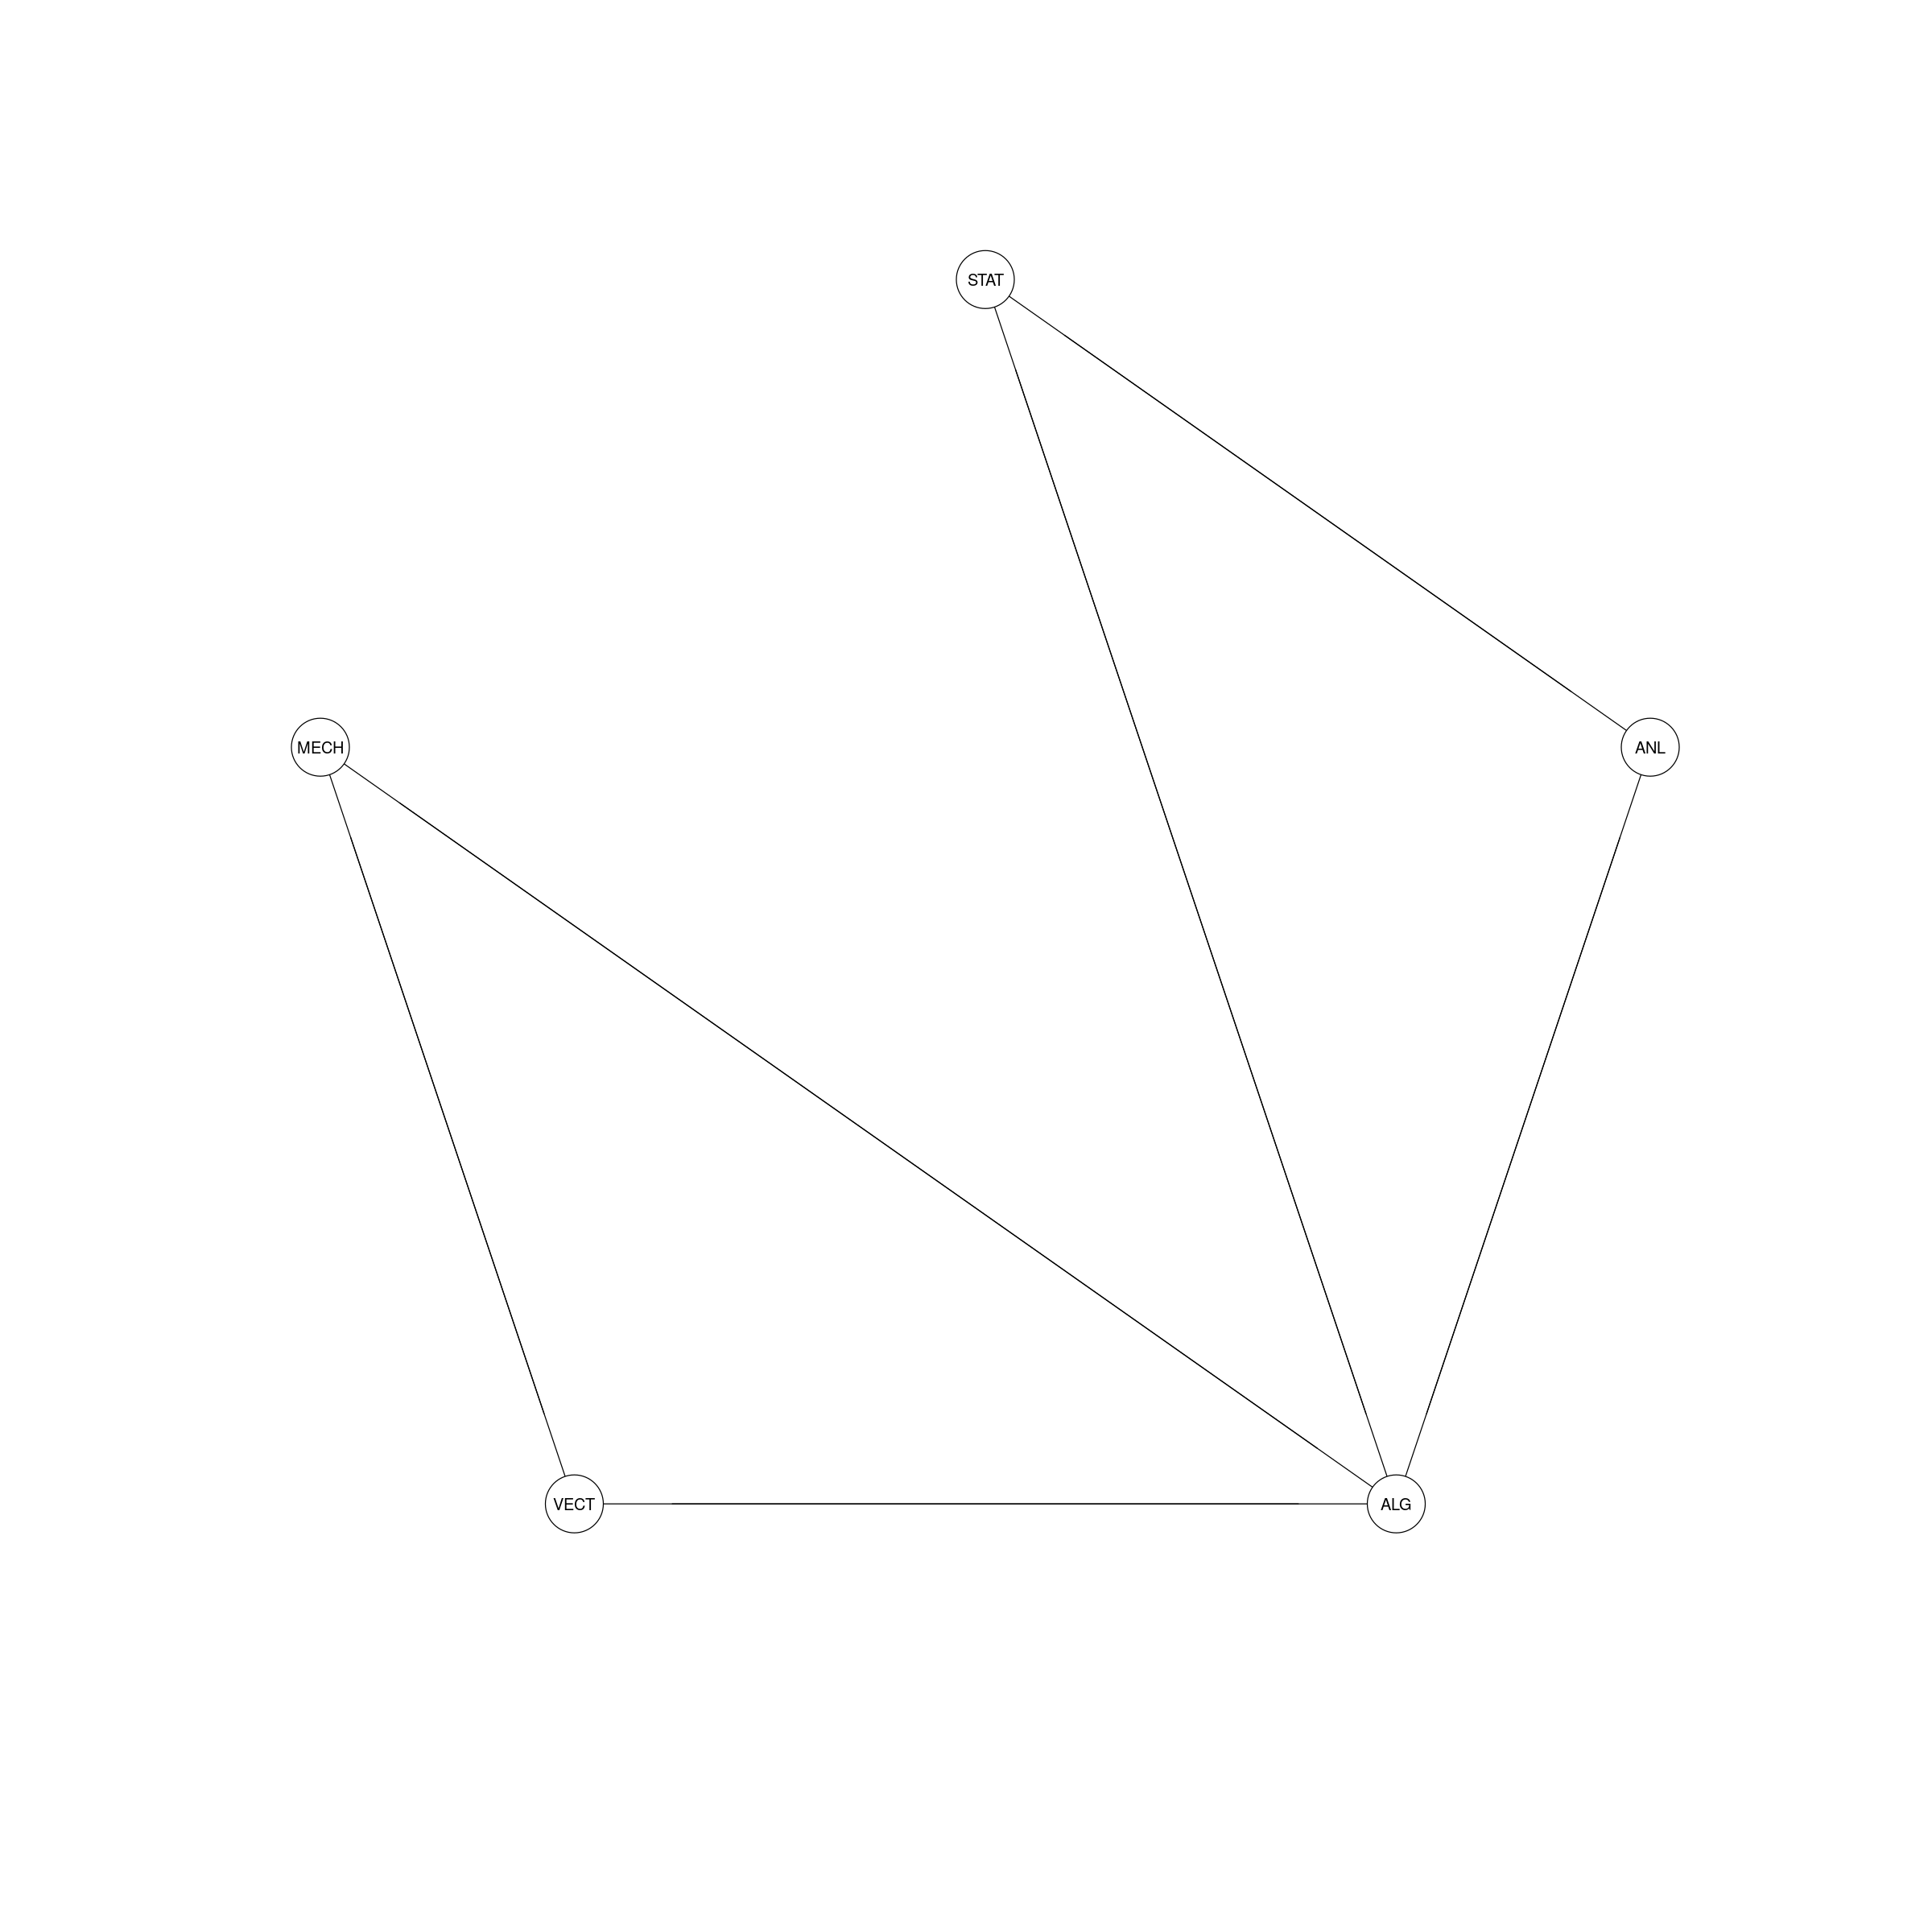

In [35]:
plot(bn.gs)

Построим граф по данным о мониторинговой системе

In [36]:
bn.iamb <- iamb(alarm)
bn.iamb

Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
“vstructure BP -> TPR <- CCHL is not applicable, because one or both arcs are oriented in the opposite direction.”
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
“vstructure BP -> CO <- STKV is not applicable, because one or both arcs are oriented in the opposite direction.”
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
“vstructure BP -> CO <- HR is not applicable, because one or both arcs are oriented in the opposite direction.”
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
“vstructure HYP -> LVV <- LVF is not applicable, because one or both arcs are oriented in the opposite direction.”



  Bayesian network learned via Constraint-based methods

  model:
    [partially directed graph]
  nodes:                                 37 
  arcs:                                  34 
    undirected arcs:                     13 
    directed arcs:                       21 
  average markov blanket size:           2.43 
  average neighbourhood size:            1.84 
  average branching factor:              0.57 

  learning algorithm:                    IAMB 
  conditional independence test:         Mutual Information (disc.) 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  6763 


Данных много, поэтому результат неплохой

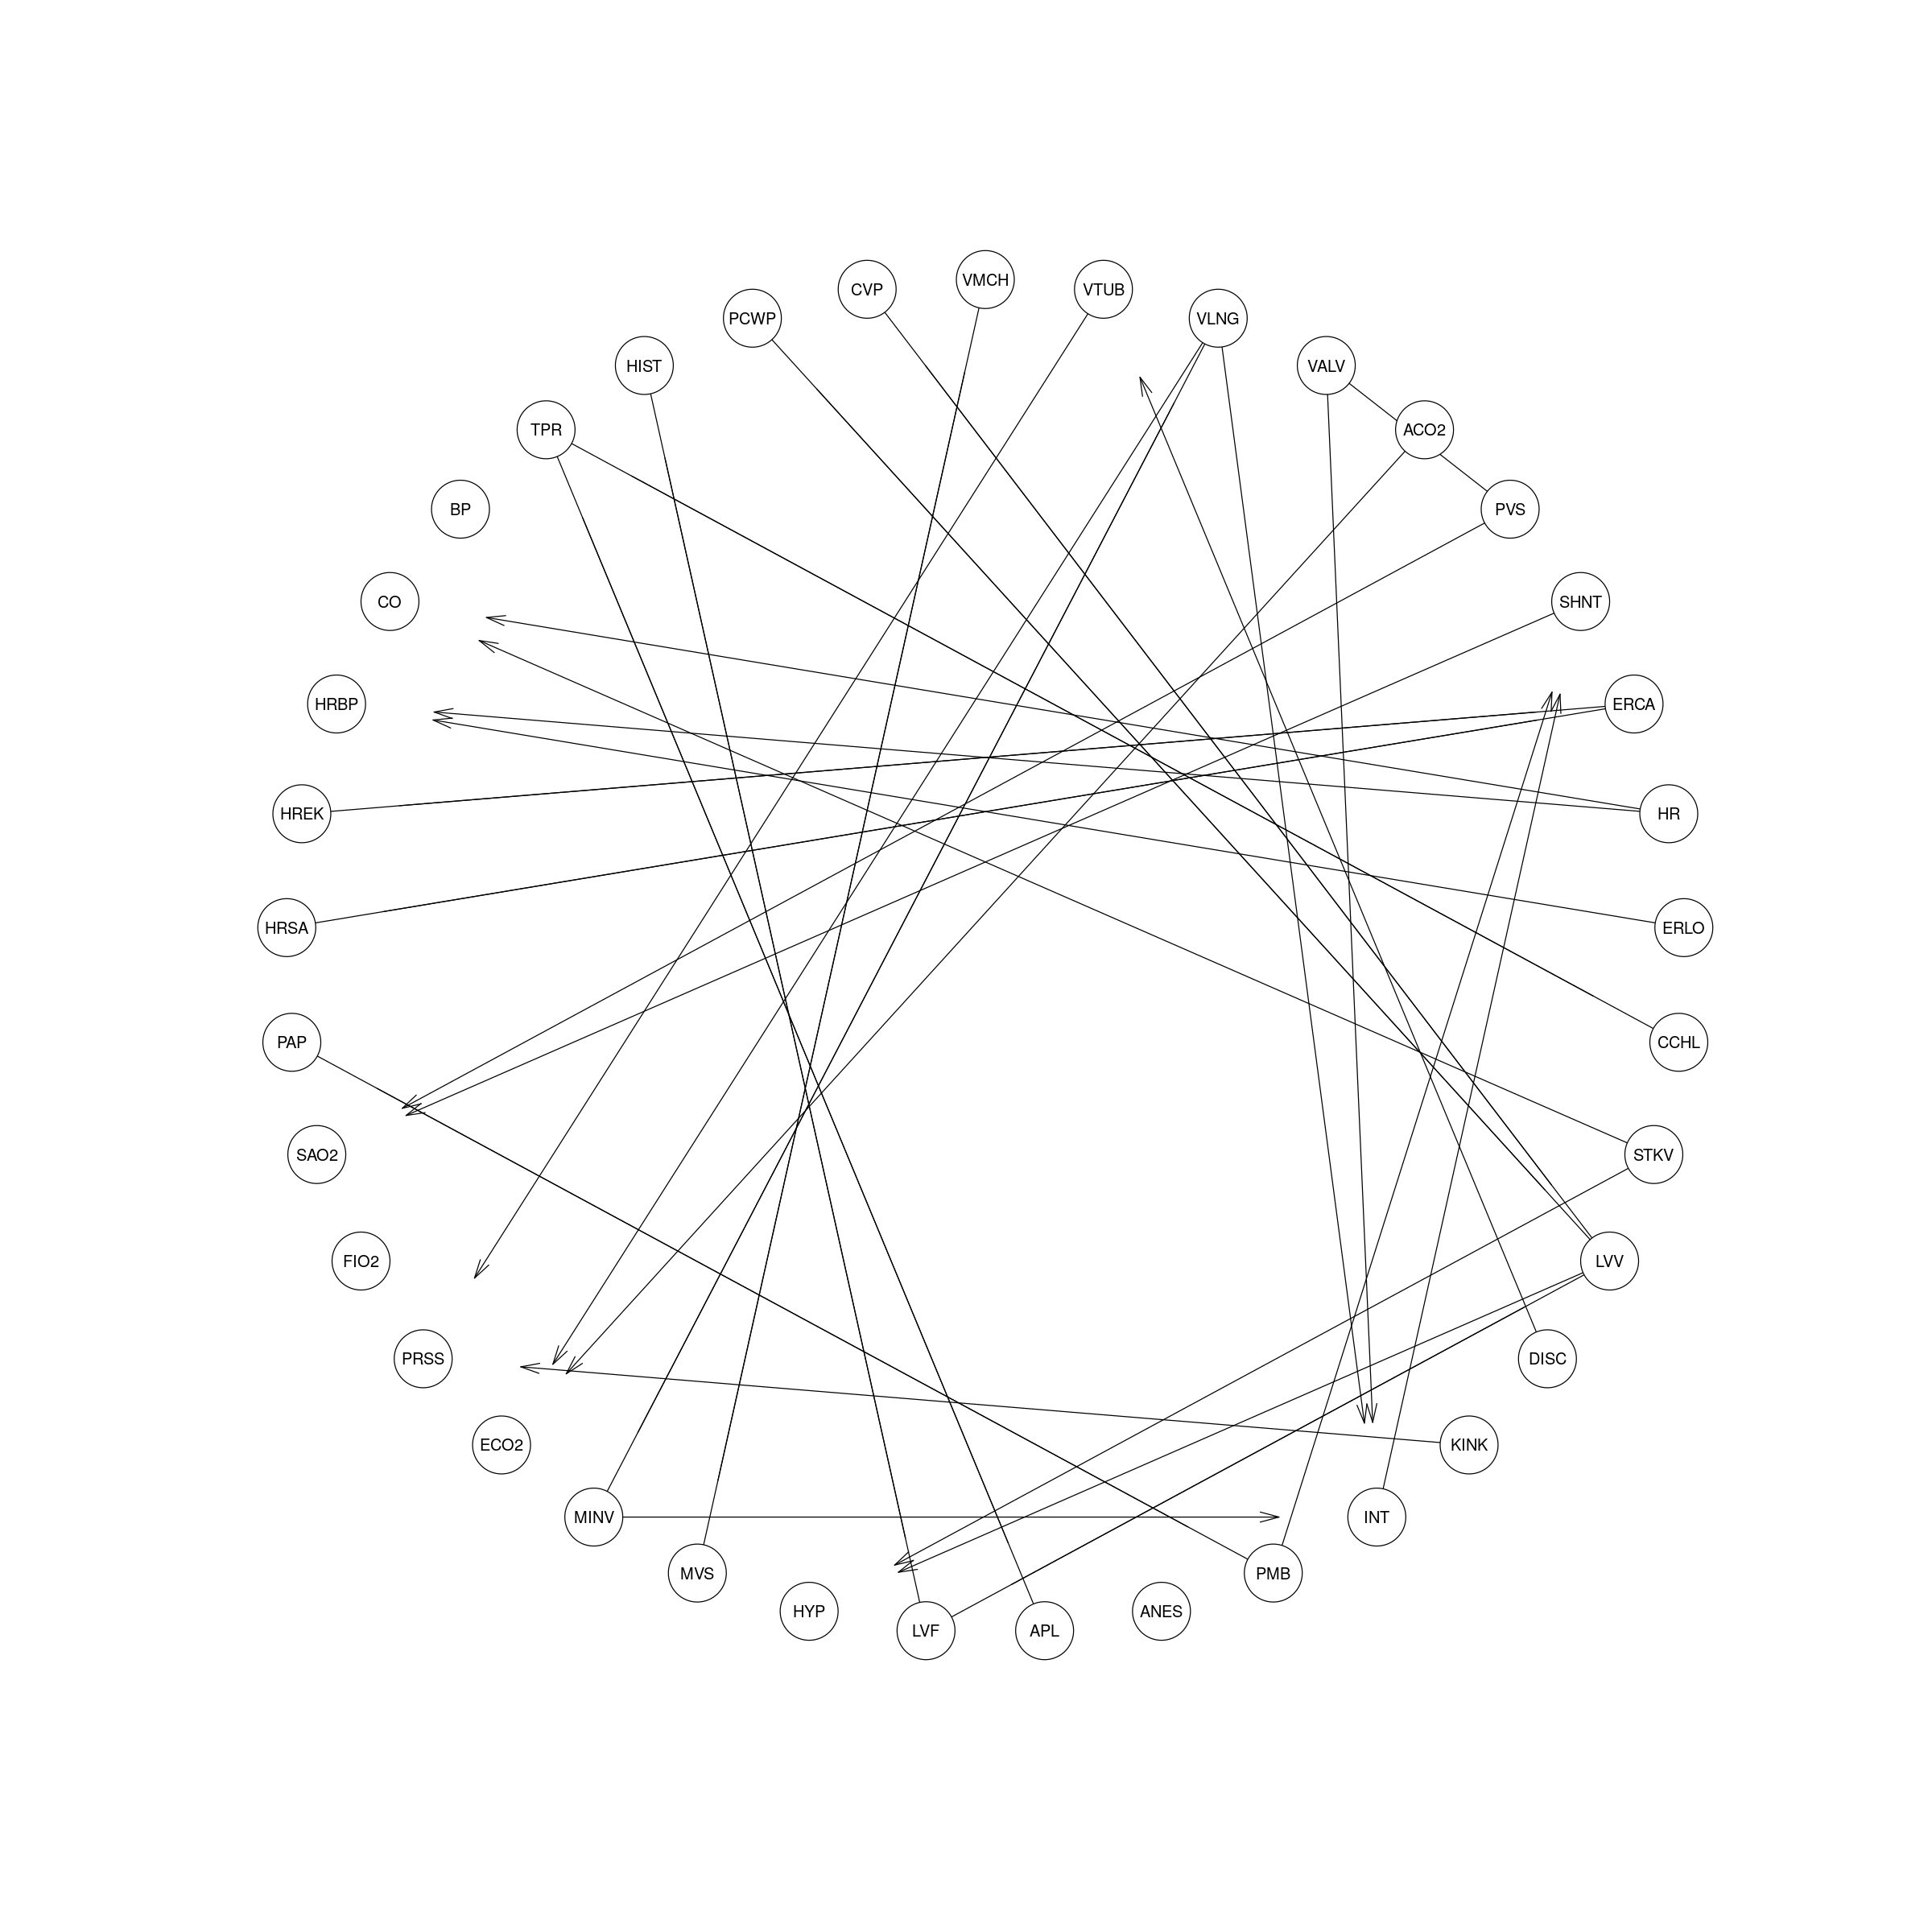

In [37]:
plot(bn.iamb)

Красивая визуализация

In [38]:
plot.network(bn.iamb, ht = "600px")

HTML widgets cannot be represented in plain text (need html)